# Benchamark CICADA performance versus supervised models

In [1]:
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, models
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from scipy import interpolate
from scipy.linalg import norm
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

In [2]:
# Setup globals

MODELS_DIRECTORY = './models'
TRAINING = False
ZERO_BIAS_DATASET = '/eos/user/a/adpol/L1AD/Background/EphemeralZeroBias2018RunD_1.h5'

In [3]:
# Setup seeds

np.random.seed(42)
tf.random.set_seed(42)

## Prepare the datasets

Load $0.5$~M ZeroBias samples as background.

In [4]:
with h5py.File(ZERO_BIAS_DATASET, 'r') as h5:
    ZeroBias = h5['CaloRegions'][:500000].astype('float32')
print('ZeroBias shape: {}'.format(ZeroBias.shape))

ZeroBias shape: (500000, 18, 14)


Load up to $0.5$~M signal samples from each process.

In [5]:
with h5py.File('/eos/user/a/adpol/L1AD/Signal/120X/GluGluHToTauTau_M-125_TuneCP5_14TeV.h5', 'r') as h5:
    GluGluHToTauTau = h5['CaloRegions'][:500000].astype('float32')
print('GluGluHToTauTau shape: {}'.format(GluGluHToTauTau.shape))

with h5py.File('/eos/user/a/adpol/L1AD/Signal/120X/GluGluToHHTo4B_node_cHHH1_TuneCP5_14TeV.h5', 'r') as h5:
    GluGluToHHTo4B = h5['CaloRegions'][:500000].astype('float32')
print('GluGluToHHTo4B shape: {}'.format(GluGluToHHTo4B.shape))

with h5py.File('/eos/user/a/adpol/L1AD/Signal/120X/TT_TuneCP5_14TeV.h5', 'r') as h5:
    TTBar = h5['CaloRegions'][:500000].astype('float32')
print('TTBar shape: {}'.format(TTBar.shape))

with h5py.File('/eos/user/a/adpol/L1AD/Signal/120X/haa4b_ma15_powheg.h5', 'r') as h5:
    Haa4b = h5['CaloRegions'][:500000].astype('float32')
print('Haa4b shape: {}'.format(Haa4b.shape))

with h5py.File('/eos/user/a/adpol/L1AD/Signal/120X/SUEP_L1_NOPU.h5', 'r') as h5:
    SUEP = h5['CaloRegions'][:500000].astype('float32')
    # Overlay SUEP samples with ZeroBias for pileup
    randomevent = np.random.randint(low=0, high=500000, size=500000)
    SUEP += ZeroBias[randomevent][:SUEP.shape[0]]
print('SUEP shape: {}'.format(SUEP.shape))

GluGluHToTauTau shape: (300000, 18, 14)
GluGluToHHTo4B shape: (100000, 18, 14)
TTBar shape: (500000, 18, 14)
Haa4b shape: (98600, 18, 14)
SUEP shape: (50000, 18, 14)


Split the datasets for fixed size training size.

In [6]:
train_size=40000 # upper-bound of SUEP samples

ZeroBias_train, ZeroBias_test = train_test_split(
    ZeroBias, train_size=train_size, random_state=42, shuffle=True)

GluGluHToTauTau_train, GluGluHToTauTau_test = train_test_split(
    GluGluHToTauTau, train_size=train_size, random_state=42, shuffle=True)

GluGluToHHTo4B_train, GluGluToHHTo4B_test = train_test_split(
    GluGluToHHTo4B, train_size=train_size, random_state=42, shuffle=True)

TTBar_train, TTBar_test = train_test_split(
    TTBar, train_size=train_size, random_state=42, shuffle=True)

Haa4b_train, Haa4b_test = train_test_split(
    Haa4b, train_size=train_size, random_state=42, shuffle=True)

SUEP_train, SUEP_test = train_test_split(
    SUEP, train_size=train_size, random_state=42, shuffle=True)

Generate a blend of signals for training

In [13]:
blend_train = np.vstack([
    GluGluHToTauTau_train[:8000],
    GluGluToHHTo4B_train[:8000],
    TTBar_train[:8000],
    Haa4b_train[:8000],
    SUEP_train[:8000]
])

## Train the supervised models

Define the model that has similar size to the CICADA.v2 student. The only difference is 2 unit output with softmax activation. The softmax does not have to be implemented in hardware so the total FPGA resource usage and latency will be very simialar.

In [15]:
def get_model():
    return keras.Sequential(
        [
            layers.Conv2D(filters=3, kernel_size=(3, 3), strides=2, padding='valid', activation='relu', input_shape=(18,14,1)),
            layers.Flatten(),
            layers.Dense(units=20, activation='relu'),
            layers.Dense(units=2, activation = 'softmax')
        ]
    )

The training uses three callbacks: early stopping, reduce on plateu and model checkpointing. Batch size, validation split and learning rate is fixed across models.

In [34]:
def train_nn(model, X, y, batch_size, loss, name, validation_split=0.0, metrics=None):
    
    early_stopper = EarlyStopping(monitor="val_loss",
                                  patience=64,
                                  verbose=True,
                                  mode="auto")
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                  factor=0.7,
                                  patience=5)

    checkpoint_callback = ModelCheckpoint(("%s/%s.h5" % (MODELS_DIRECTORY, name)),
                                          monitor="val_loss",
                                          verbose=False,
                                          save_weights_only=False,
                                          save_best_only=True,
                                          mode="min")

    opt = keras.optimizers.Adam(learning_rate=0.001,
                                beta_1=0.9,
                                beta_2=0.999,
                                epsilon=None,
                                decay=0.0,
                                amsgrad=False)

    model.compile(loss=loss, metrics=metrics, optimizer=opt)

    return model.fit(X, y,
                     batch_size=batch_size,
                     epochs=8192,
                     verbose=0,
                     initial_epoch=0,
                     shuffle=True,
                     validation_split=validation_split,
                     callbacks=[early_stopper, reduce_lr, checkpoint_callback])

Define helper function to plot loss and accuracy

In [35]:
def plot_loss(training):
    fig, ax1 = plt.subplots()
    ax1.set_xlabel("Epoch", horizontalalignment='right', x=1.0)
    ax1.set_ylabel("Loss", horizontalalignment='right', y=1.0)
    ax1.set_yscale('log')
    ax1.tick_params(axis='y', labelcolor='red')
    ax1.plot(training.history['loss'],
             label='Training')
    ax1.plot(training.history['val_loss'],
             label='Validation')
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy', color='black')
    ax2.tick_params(axis='y', labelcolor='black')
    ax2.plot(training.history['val_accuracy'],
             color='green',
             label='Val Accuracy')
    ax1.legend(bbox_to_anchor=(1.1, 1.00), loc='upper left')
    ax2.legend(bbox_to_anchor=(1.1, 0.00), loc='lower left')
    plt.show(fig)

Train the supervised model and save them to directory. The blend model has an issue with generalization. It will likely have to have either more capacity, experience or both to understand difference between the background and low-PT (and high-PT) signal samples.

Epoch 00111: early stopping


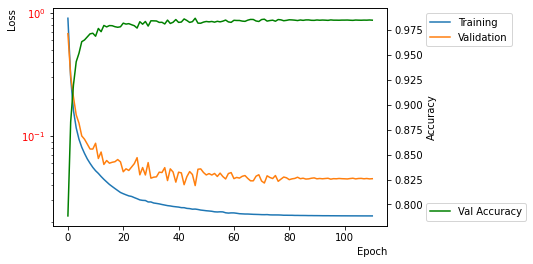

Epoch 00103: early stopping


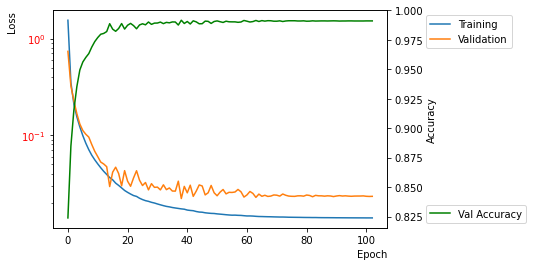

Epoch 00099: early stopping


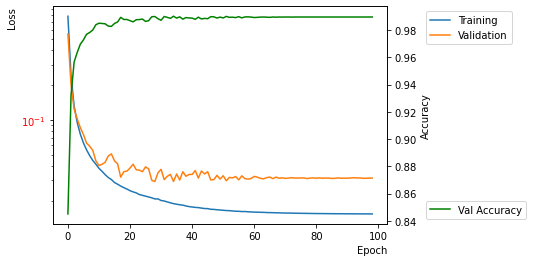

Epoch 00101: early stopping


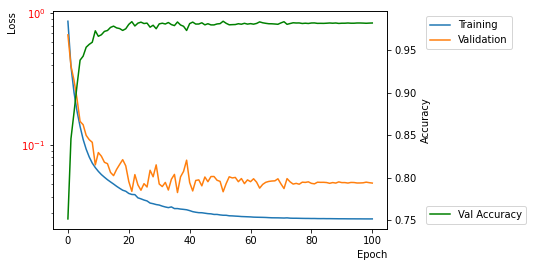

Epoch 00109: early stopping


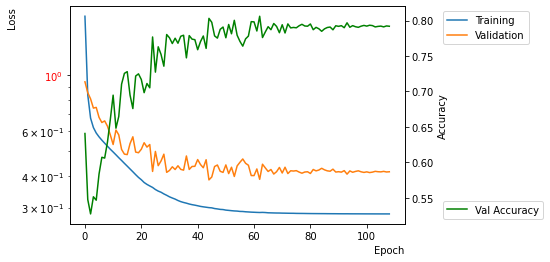

Epoch 00065: early stopping


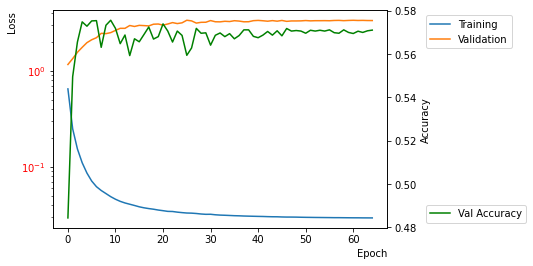

In [38]:
def supervised_training(signal, name):

    model = get_model()

    X_train = np.expand_dims(np.append(ZeroBias_train, signal, axis=0), axis=-1)
    y_train = np.append(np.zeros(len(ZeroBias_train)), np.ones(len(signal)), axis=0)
    y_train = keras.utils.to_categorical(y_train, 2)

    training = train_nn(
        model,
        X_train,
        y_train,
        2048,
        "categorical_crossentropy",
        name,
        validation_split=0.2,
        metrics="accuracy")

    plot_loss(training)

if TRAINING:
    supervised_training(GluGluHToTauTau_train, "m_GluGluHToTauTau")
    supervised_training(GluGluToHHTo4B_train, "m_GluGluToHHTo4B")
    supervised_training(TTBar_train, "m_TTBar")
    supervised_training(Haa4b_train, "m_Haa4b")
    supervised_training(SUEP_train, "m_SUEP")
    supervised_training(blend_train, "m_blend")

In [39]:
cicada_v1 = models.load_model('./ML_CMSL1CaloTrigger/saved_models/model_sA')
cicada_v2 = models.load_model('./ML_CMSL1CaloTrigger/saved_models/qmodel_oct24')

## Evaluation

Three metrics to collect: ROC AUC, efficiency at 5kHz and efficiency at 3 kHz. Each model is evaluated on all test datasets.

In [44]:
matrix_auc = np.zeros((5,9))
matrix_eff_5hz = np.zeros((5,9))
matrix_eff_3hz = np.zeros((5,9))

for x_idx, signal in enumerate(
    [GluGluHToTauTau_test,
     GluGluToHHTo4B_test,
     TTBar_test,
     Haa4b_test,
     SUEP_test]):

    X_test = np.expand_dims(np.append(ZeroBias_test, signal, axis=0), axis=-1)
    y_test = np.append(np.zeros(len(ZeroBias_test)), np.ones(len(signal)), axis=0)

    for y_idx, name in enumerate(
        ["m_GluGluHToTauTau",
         "m_GluGluToHHTo4B",
         "m_TTBar",
         "m_Haa4b",
         "m_SUEP",
         "m_blend"]):

        model = get_model()
        model.load_weights("{}/{}.h5".format(MODELS_DIRECTORY, name))

        fpr, tpr, _ = roc_curve(y_test, model.predict(X_test)[:,-1])
        
        roc_auc = auc(fpr, tpr)
        interpolated = interpolate.interp1d(fpr*28.61, tpr)
        eff5hz = interpolated(0.005)
        eff3hz = interpolated(0.003)
        
        matrix_auc[x_idx][y_idx] = roc_auc
        matrix_eff_5hz[x_idx][y_idx] = eff5hz
        matrix_eff_3hz[x_idx][y_idx] = eff3hz

    # Add baseline
    pileup = np.mean(ZeroBias_train, axis=0)
    fnorm = norm(X_test-pileup.reshape(18, 14, 1), ord=None, axis=(1,2), keepdims=False)
    fpr, tpr, _ = roc_curve(y_test, fnorm)
    roc_auc = auc(fpr, tpr)
    interpolated = interpolate.interp1d(fpr*28.61, tpr)
    eff5hz = interpolated(0.005)
    eff3hz = interpolated(0.003)
    matrix_auc[x_idx][6] = roc_auc
    matrix_eff_5hz[x_idx][6] = eff5hz
    matrix_eff_3hz[x_idx][6] = eff3hz
    
    # Add CICADA_V1
    score = cicada_v1.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, score)
    roc_auc = auc(fpr, tpr)
    interpolated = interpolate.interp1d(fpr*28.61, tpr)
    eff5hz = interpolated(0.005)
    eff3hz = interpolated(0.003)

    matrix_auc[x_idx][7] = roc_auc
    matrix_eff_5hz[x_idx][7] = eff5hz
    matrix_eff_3hz[x_idx][7] = eff3hz
    
    # Add CICADA_V2
    score = cicada_v2.predict(X_test.reshape(-1, 252))
    fpr, tpr, _ = roc_curve(y_test, score)
    roc_auc = auc(fpr, tpr)
    interpolated = interpolate.interp1d(fpr*28.61, tpr)
    eff5hz = interpolated(0.005)
    eff3hz = interpolated(0.003)

    matrix_auc[x_idx][8] = roc_auc
    matrix_eff_5hz[x_idx][8] = eff5hz
    matrix_eff_3hz[x_idx][8] = eff3hz

In [45]:
models = [r"$\mathcal{M}_{H \rightarrow \tau \tau}$",
          r"$\mathcal{M}_{\rm{SM }~HH \rightarrow 4b}$",
          r"$\mathcal{M}_{T{\bar{T}}}$",
          r"$\mathcal{M}_{H \rightarrow aa \rightarrow 4b}$",
          r"$\mathcal{M}_{\rm{SUEP}}$",
          r"$\mathcal{M}_{\rm{BLEND}}$",
          r"$\mathcal{M}_{\rm{Baseline}}$",
          r"$\mathcal{M}_{\rm{CICADA.v1}}$",
          r"$\mathcal{M}_{\rm{CICADA.v2}}$"]
datasets = [r"$\mathcal{D}_{H \rightarrow \tau \tau}$",
          r"$\mathcal{D}_{\rm{SM }~HH \rightarrow 4b}$",
          r"$\mathcal{D}_{T{\bar{T}}}$",
          r"$\mathcal{D}_{H \rightarrow aa \rightarrow 4b}$",
          r"$\mathcal{D}_{\rm{SUEP}}$"]

In [66]:
def plot_matrix(matrix, title):
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(matrix, cmap='RdYlGn', vmin=np.min(matrix), vmax=np.max(matrix))
    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(models)), labels=models)
    ax.set_yticks(np.arange(len(datasets)), labels=datasets)
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    for i in range(len(datasets)):
        for j in range(len(models)):
            text = ax.text(j, i, "{0:.2f}".format(matrix[i, j]),
                           ha="center", va="center", color="black")
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    fig.tight_layout()
    plt.title(title)
    plt.show()

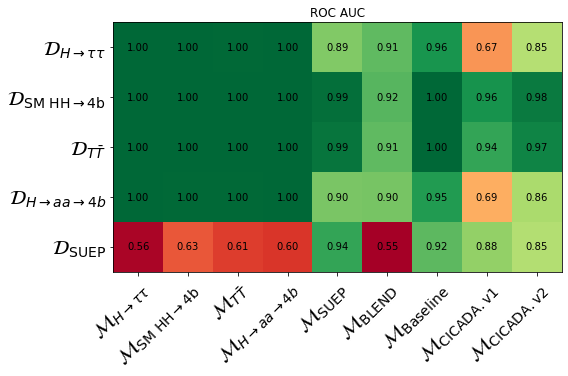

In [67]:
plot_matrix(matrix_auc, "ROC AUC")

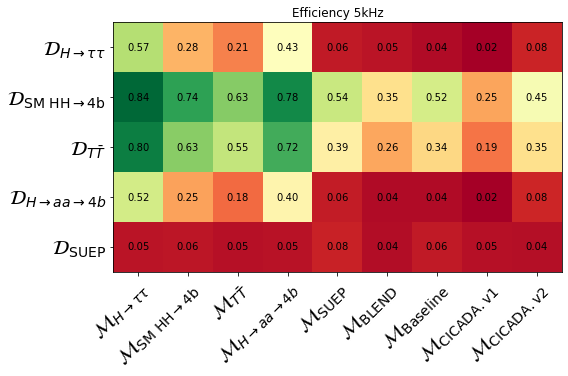

In [68]:
plot_matrix(matrix_eff_5hz, "Efficiency 5kHz")

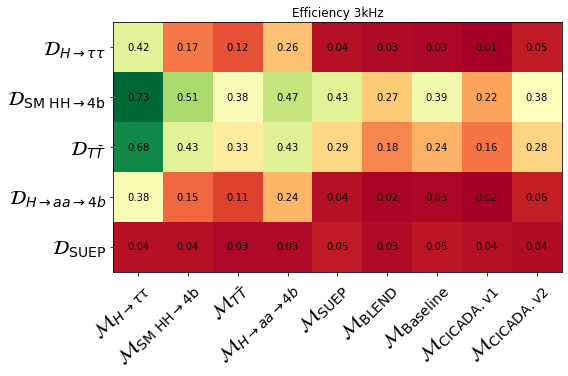

In [69]:
plot_matrix(matrix_eff_3hz, "Efficiency 3kHz")

In [3]:
# Old results

# matrix_auc = np.array([[0.99931113, 0.99828255, 0.99808755, 0.99922401, 0.88706181,
#         0.95608817, 0.85202834],
#        [0.99955772, 0.99971795, 0.99972707, 0.99930804, 0.99418636,
#         0.99887375, 0.98046124],
#        [0.99945533, 0.99957627, 0.99962504, 0.999235  , 0.98971935,
#         0.99813403, 0.97247122],
#        [0.9990662 , 0.99804866, 0.99770207, 0.9990725 , 0.89391579,
#         0.94941153, 0.86027246],
#        [0.63831957, 0.66608338, 0.67333092, 0.6045449 , 0.95096123,
#         0.91529347, 0.85318879]])

# matrix_eff_5hz = np.array([[0.38893921, 0.29617876, 0.26728668, 0.55295627, 0.05144186,
#         0.03779231, 0.07773462],
#        [0.54655364, 0.71407297, 0.71268912, 0.86307385, 0.5584814 ,
#         0.5192    , 0.44648333],
#        [0.52595375, 0.64400931, 0.64128078, 0.81445631, 0.38914821,
#         0.33528261, 0.34921087],
#        [0.36914348, 0.26529594, 0.235209  , 0.52985782, 0.05275465,
#         0.0371843 , 0.08151877],
#        [0.04196908, 0.0573003 , 0.05489095, 0.05490876, 0.07895385,
#         0.0635    , 0.0445    ]])

# matrix_eff_3hz = np.array([[0.23336353, 0.17770726, 0.16037201, 0.33606965, 0.03155303,
#         0.02521154, 0.05398077],
#        [0.32793218, 0.42844378, 0.42761347, 0.5310372 , 0.3525434 ,
#         0.39361667, 0.3762    ],
#        [0.31557225, 0.38640559, 0.38476847, 0.50012099, 0.24372038,
#         0.23594783, 0.28371522],
#        [0.22148609, 0.15917757, 0.1411254 , 0.32194579, 0.03255169,
#         0.02527304, 0.05832765],
#        [0.02518145, 0.03438018, 0.03293457, 0.03339338, 0.04913527,
#         0.0493    , 0.0354    ]])